# Assignment 2024 S2
## Part 1: Computer vision - Training from scratch vs Transfer learning

Citation: Some code has been generated with the help of Claude 3.5 Sonnet by Anthropic, and some decisions and further clarifications were made with gemini-2.0-flash-thinking-exp-01-21

### Selecting dataset
https://universe.roboflow.com/hung-5yuey/face-emotion-8vfzj

This is a face emotion computer vision dataset.

The reason why I chose this dataset is because it presents an excellent balance of complexity and accessibility for demonstrating both training a deep learning model from scratch and applying transfer learning techniques.  

Face emotion recognition is a computer vision task that requires capturing subtle facial expressions, making it complex enough to showcase the benefits of transfer learning from pre-trained models which have already learned generalizable image features.  

At the same time, face emotion datasets are readily available and often reasonably sized, allowing for training from scratch within the constraints of a typical assignment without requiring excessive computational resources or training time.  

Furthermore, the task itself is intuitively understandable and relatable, making it easier to interpret the performance differences between models trained using different approaches and to appreciate the practical implications of transfer learning in computer vision.

Transfer learning is particularly effective in computer vision tasks, because they usually consist of basic visual features that pre-trained models have already learned, like edges, textures, and shapes.

And while 5000 images is a decent size, It's not considered massive for training a complex deep learning model. Transfer learning is beneficial when you have limited data for your predictive task, because it leverages knowledge from the ofter larger and comprehensive pre-trained dataset, like ImageNet.

However, we must consider the domain gap between general object recognition and specific emotion recognition. Fine-tuning will be necessary to adapt the pre-trained features to the emotion recognition task. As such, simply using the pre-trained model as a feature extractor won't be optimal.




In [68]:
# Standard library imports
import logging
import time
from pathlib import Path

# Data handling & visualization
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Machine learning & PyTorch
import torch
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchinfo import summary
from sklearn.metrics import confusion_matrix, classification_report

# Local imports
from dataset import EmotionDataset

In [69]:
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

CONFIG = {
    # Data parameters
    "batch_size": 32,
    "image_size": 224,
    "num_workers": 4,
    "mean": [0.485, 0.456, 0.406],
    "std": [0.229, 0.224, 0.225],
    "base_path": Path("./face_emotion/"),
    
    # Training parameters
    "num_epochs": 10,
    
    # Evaluation parameters
    "num_samples": 10,
}


device = torch.device("mps"
                      if torch.backends.mps.is_available()
                      else "cpu")

splits = ["train", "valid", "test"]
dataset_paths = {split: CONFIG["base_path"] / split for split in splits}


data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop(CONFIG["image_size"]),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(CONFIG["mean"], CONFIG["std"]),
        ]
    ),
    "valid": transforms.Compose(
        [
            transforms.Resize(int(CONFIG["image_size"] * 1.14)),
            transforms.CenterCrop(CONFIG["image_size"]),
            transforms.ToTensor(),
            transforms.Normalize(CONFIG["mean"], CONFIG["std"]),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.Resize(int(CONFIG["image_size"] * 1.14)),
            transforms.CenterCrop(CONFIG["image_size"]),
            transforms.ToTensor(),
            transforms.Normalize(CONFIG["mean"], CONFIG["std"]),
        ]
    ),
}


image_datasets = {
    split: EmotionDataset(str(dataset_paths[split]), data_transforms[split])
    for split in splits
}
dataloaders = {
    split: DataLoader(
        image_datasets[split],
        batch_size=CONFIG["batch_size"],
        shuffle=(split == "train"),
        num_workers=CONFIG["num_workers"],
        pin_memory=True,
        drop_last=(split == "train"),
    )
    for split in splits
}

dataset_sizes = {split: len(image_datasets[split]) for split in splits}
class_names = [name.strip() for name in image_datasets["train"].classes]

In [70]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=CONFIG["num_epochs"], model_name="Model",):
    """Train a model and save the best weights"""
    best_val_acc = 0.0
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    # Move model to device once
    model = model.to(device)
    criterion = criterion.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = running_corrects = 0

        train_pbar = tqdm(
            dataloaders["train"], desc="Training Phase", position=1, leave=False
        )

        for inputs, labels in train_pbar:
            # Move batch to device
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # Zero gradients
            optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()

            # Regular training
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            with torch.no_grad():
                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            train_pbar.set_postfix({"loss": f"{loss.item():.4f}"})

        epoch_loss = running_loss / dataset_sizes["train"]
        epoch_acc = running_corrects.float() / dataset_sizes["train"]
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc.item())

        # Validation phase
        model.eval()
        running_loss = running_corrects = 0
        valid_pbar = tqdm(
            dataloaders["valid"], desc="Validation Batches", position=1, leave=False
        )

        with torch.no_grad():
            for inputs, labels in valid_pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                valid_pbar.set_postfix({"loss": f"{loss.item():.4f}"})

        epoch_loss = running_loss / dataset_sizes["valid"]
        epoch_acc = running_corrects.float() / dataset_sizes["valid"]
        val_losses.append(epoch_loss)
        val_accs.append(epoch_acc.item())

        # Scheduler and logging phase
        logger.info(f"Epoch {epoch+1}/{num_epochs}")
        logger.info(f"Train Loss: {train_losses[-1]:.4f} Acc: {train_accs[-1]:.4f}")
        logger.info(f"Val Loss: {val_losses[-1]:.4f} Acc: {val_accs[-1]:.4f}")

        scheduler.step(epoch_loss)
        if epoch_acc > best_val_acc:
            best_val_acc = epoch_acc
            print("Saving best model checkpoint...")
            torch.save(model.state_dict(), f"best_{model_name}.pth")

    # Plot training history
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(train_losses, label="Train")
    ax1.plot(val_losses, label="Val")
    ax1.set_title("Loss")
    ax1.set_xlabel("Epoch")
    ax1.legend()

    ax2.plot(train_accs, label="Train")
    ax2.plot(val_accs, label="Val")
    ax2.set_title("Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.legend()

    plt.tight_layout()
    plt.show()

    return train_losses, val_losses, train_accs, val_accs

### Training from scratch

In [71]:
class EmotionNet(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Local feature pathway (focuses on smaller facial details)
        self.local_path = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.MaxPool2d(2),
        )

        # Global feature pathway (focuses on overall facial expression)
        self.global_path = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=7, padding=3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.MaxPool2d(2),
        )

        # Fusion and classification layers
        self.fusion = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(256),
            torch.nn.MaxPool2d(2),
            torch.nn.Dropout2d(0.3),
        )

        # Calculate the size after convolutions and pooling
        # Input size is 224x224
        # After 3 MaxPool2d operations: 28x28
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(256 * 28 * 28, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, num_classes),
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(
                    m.weight, mode="fan_out", nonlinearity="relu"
                )
            elif isinstance(m, torch.nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, 0, 0.01)
                torch.nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Process through both pathways
        local_features = self.local_path(x)
        global_features = self.global_path(x)

        # Concatenate features from both pathways
        combined = torch.cat([local_features, global_features], dim=1)

        # Fusion and classification
        fused = self.fusion(combined)
        flattened = fused.view(fused.size(0), -1)
        output = self.classifier(flattened)

        return output


model = EmotionNet(num_classes=len(class_names))
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
EmotionNet                               [1, 7]                    --
├─Sequential: 1-1                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-1                       [1, 32, 224, 224]         896
│    └─ReLU: 2-2                         [1, 32, 224, 224]         --
│    └─BatchNorm2d: 2-3                  [1, 32, 224, 224]         64
│    └─MaxPool2d: 2-4                    [1, 32, 112, 112]         --
│    └─Conv2d: 2-5                       [1, 64, 112, 112]         18,496
│    └─ReLU: 2-6                         [1, 64, 112, 112]         --
│    └─BatchNorm2d: 2-7                  [1, 64, 112, 112]         128
│    └─MaxPool2d: 2-8                    [1, 64, 56, 56]           --
├─Sequential: 1-2                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-9                       [1, 32, 224, 224]         4,736
│    └─ReLU: 2-10                        [1, 32, 224, 224]         --
│    └

Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 17:36:50,110 - INFO - Epoch 1/10
2025-02-20 17:36:50,115 - INFO - Train Loss: 16.5227 Acc: 0.2057
2025-02-20 17:36:50,116 - INFO - Val Loss: 5.3243 Acc: 0.2343


Saving best model checkpoint...


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 17:39:21,268 - INFO - Epoch 2/10
2025-02-20 17:39:21,274 - INFO - Train Loss: 2.3381 Acc: 0.2501
2025-02-20 17:39:21,275 - INFO - Val Loss: 2.0148 Acc: 0.2490


Saving best model checkpoint...


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x117ce2280>
Traceback (most recent call last):
  File "/Users/siewweiheng/miniconda3/envs/adl-1/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/Users/siewweiheng/miniconda3/envs/adl-1/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1576, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x117ce2280>
Traceback (most recent call last):
  File "/Users/siewweiheng/miniconda3/envs/adl-1/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/Users/siewweiheng/miniconda3/envs/adl-1/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1576, in _shutdown

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 17:43:24,553 - INFO - Epoch 3/10
2025-02-20 17:43:24,558 - INFO - Train Loss: 1.9621 Acc: 0.2576
2025-02-20 17:43:24,559 - INFO - Val Loss: 2.0846 Acc: 0.2559


Saving best model checkpoint...


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 17:48:16,301 - INFO - Epoch 4/10
2025-02-20 17:48:16,306 - INFO - Train Loss: 2.6419 Acc: 0.2509
2025-02-20 17:48:16,306 - INFO - Val Loss: 1.9391 Acc: 0.2500


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 17:53:08,672 - INFO - Epoch 5/10
2025-02-20 17:53:08,676 - INFO - Train Loss: 1.9061 Acc: 0.2599
2025-02-20 17:53:08,676 - INFO - Val Loss: 1.8935 Acc: 0.2520


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 17:57:14,865 - INFO - Epoch 6/10
2025-02-20 17:57:14,869 - INFO - Train Loss: 1.8870 Acc: 0.2596
2025-02-20 17:57:14,870 - INFO - Val Loss: 1.8839 Acc: 0.2530


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 18:00:48,952 - INFO - Epoch 7/10
2025-02-20 18:00:48,956 - INFO - Train Loss: 1.9291 Acc: 0.2596
2025-02-20 18:00:48,957 - INFO - Val Loss: 1.8789 Acc: 0.2549


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 18:04:56,144 - INFO - Epoch 8/10
2025-02-20 18:04:56,148 - INFO - Train Loss: 1.8869 Acc: 0.2596
2025-02-20 18:04:56,149 - INFO - Val Loss: 1.8790 Acc: 0.2549


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 18:09:16,716 - INFO - Epoch 9/10
2025-02-20 18:09:16,720 - INFO - Train Loss: 1.8763 Acc: 0.2596
2025-02-20 18:09:16,721 - INFO - Val Loss: 1.8789 Acc: 0.2549


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 18:13:23,573 - INFO - Epoch 10/10
2025-02-20 18:13:23,577 - INFO - Train Loss: 1.8725 Acc: 0.2596
2025-02-20 18:13:23,577 - INFO - Val Loss: 1.8789 Acc: 0.2539


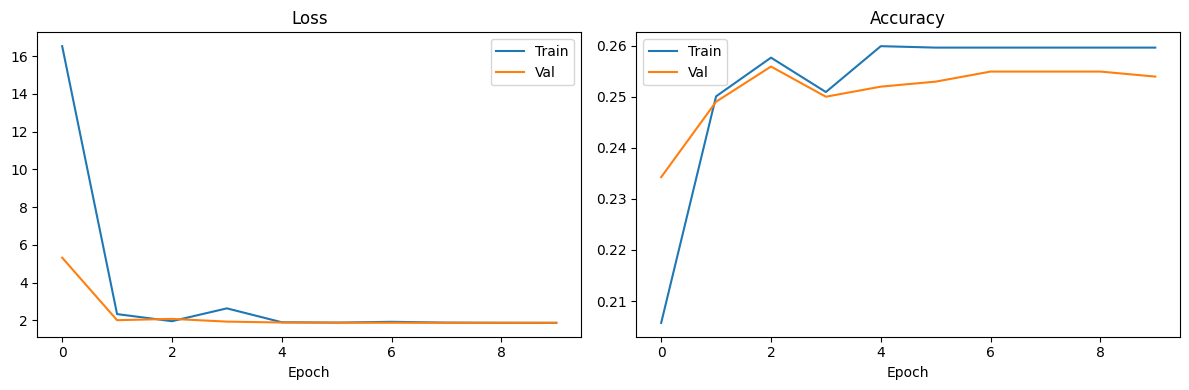

In [72]:
criterion = torch.nn.CrossEntropyLoss()
# Higher learning rate for training from scratch
optimizer = torch.optim.AdamW(model.parameters(), lr=0.003, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.2,
    patience=7,
)

# Train the model using the train_model function
train_losses, val_losses, train_accs, val_accs = train_model(
    model=model,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    model_name="Custom_EmotionNet"
)

The custom model shows signs of overfitting.

In [73]:
def evaluate_model(model, dataloader, device, model_name="Model", num_samples=CONFIG["num_samples"]):
    """Evaluate model with detailed metrics and visualizations"""
    model.eval()
    all_preds, all_labels = [], []
    sample_images, sample_preds, sample_labels = [], [], []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(dataloader, desc=f"Evaluating {model_name}")):
            # Store sample images for visualization
            if len(sample_images) < num_samples:
                idx = min(num_samples - len(sample_images), inputs.size(0))
                sample_images.extend([inputs[:idx]])
                sample_labels.extend(labels[:idx].cpu().numpy())

            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            if len(sample_preds) < num_samples:
                sample_preds.extend(preds[:idx].cpu().numpy())

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = sum(1 for x, y in zip(all_preds, all_labels) if x == y) / len(all_labels)
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=class_names, digits=3)

    # Visualize sample predictions
    if sample_images:
        sample_images = torch.cat(sample_images, dim=0)
        fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))

        # Denormalize images
        mean = torch.tensor(CONFIG["mean"]).view(3, 1, 1)
        std = torch.tensor(CONFIG["std"]).view(3, 1, 1)
        sample_images = sample_images * std + mean

        for idx in range(num_samples):
            img = sample_images[idx].cpu().permute(1, 2, 0).numpy()
            img = np.clip(img, 0, 1)
            axes[idx].imshow(img)
            axes[idx].set_title(f"True: {class_names[sample_labels[idx]]}\nPred: {class_names[sample_preds[idx]]}")
            axes[idx].axis("off")

        plt.suptitle(f"{model_name} - Sample Predictions")
        plt.tight_layout()
        plt.show()

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(f"\nClassification Report - {model_name}")
    print(report)

    return accuracy, cm, report

Evaluating Custom Model:   0%|          | 0/16 [00:00<?, ?it/s]

/Users/siewweiheng/miniconda3/envs/adl-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/siewweiheng/miniconda3/envs/adl-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/siewweiheng/miniconda3/envs/adl-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

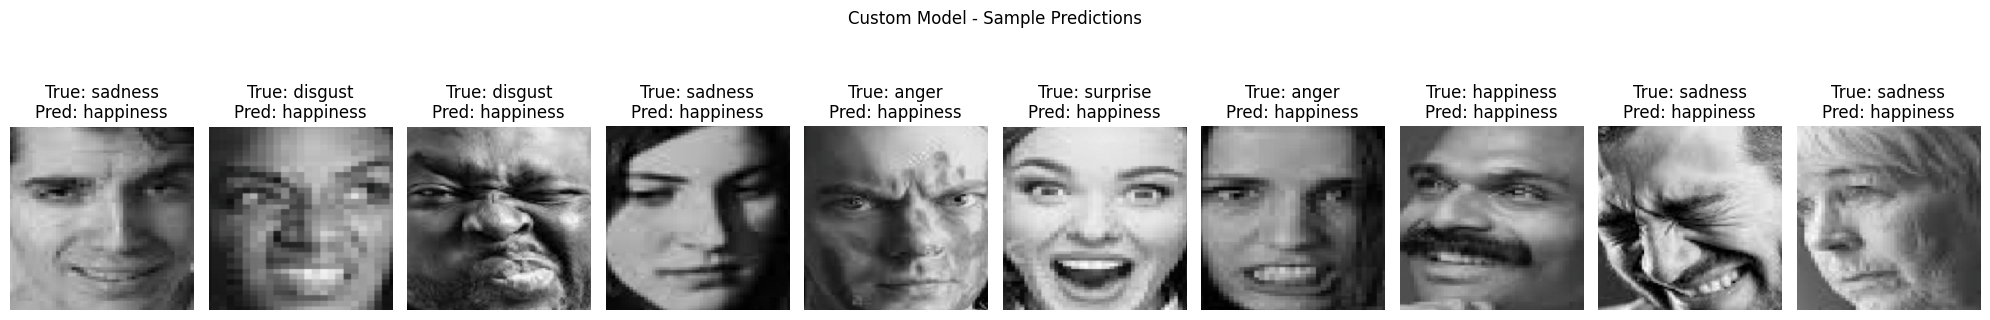

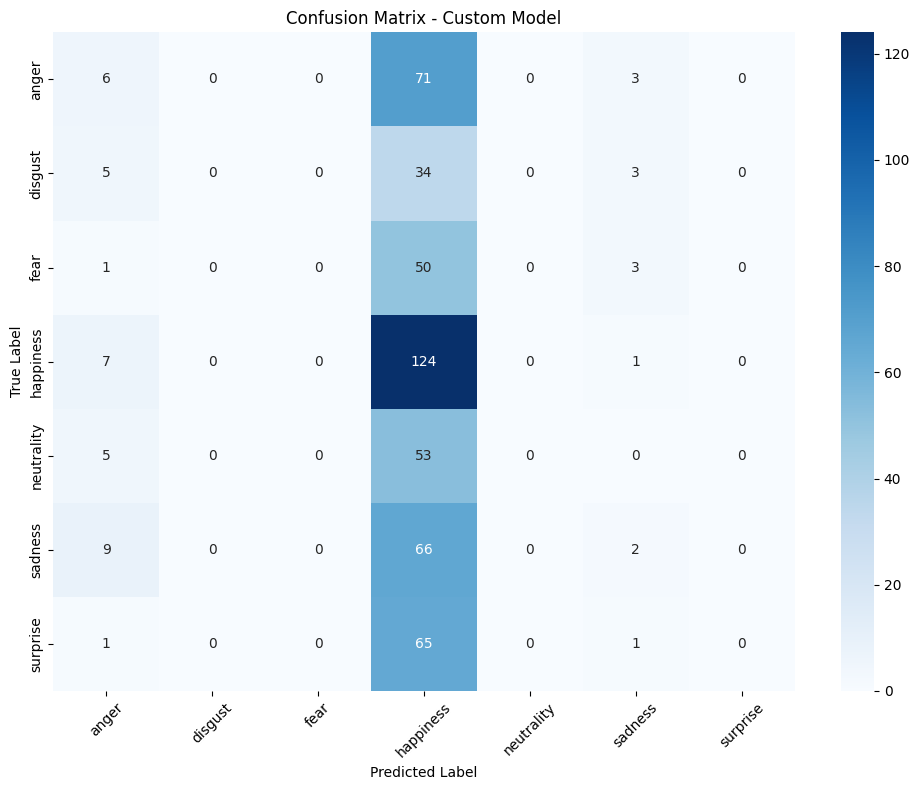


Classification Report - Custom Model
              precision    recall  f1-score   support

       anger      0.176     0.075     0.105        80
     disgust      0.000     0.000     0.000        42
        fear      0.000     0.000     0.000        54
   happiness      0.268     0.939     0.417       132
  neutrality      0.000     0.000     0.000        58
     sadness      0.154     0.026     0.044        77
    surprise      0.000     0.000     0.000        67

    accuracy                          0.259       510
   macro avg      0.085     0.149     0.081       510
weighted avg      0.120     0.259     0.131       510



In [74]:
custom_model = EmotionNet(num_classes=len(class_names)).to(device)
custom_model.load_state_dict(torch.load("best_Custom_EmotionNet.pth"))
custom_acc, custom_cm, custom_report = evaluate_model(custom_model, dataloaders["test"], device, "Custom Model")

CustomModel V1 (EmotionNet):
1. Simple dual-pathway architecture:
   - Local path: Small kernels (3x3) for detailed features
   - Global path: Larger kernels (7x7, 5x5) for overall expression
2. Basic fusion with concatenation
3. Large and inefficient architecture (103M parameters)
4. No attention mechanisms
5. Basic linear classifier
Problems:
  * It was like using a sledgehammer to crack a nut (way too big with 103M parameters)
  * Local and Global paths worked independently without sharing any initial info
  * Very basic in how it combined information
  * Not very smart about what parts of the face to focus on

In [75]:
class EmotionNetV2(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Self-attention module
        class SelfAttention(torch.nn.Module):
            def __init__(self, in_channels):
                super().__init__()
                self.query = torch.nn.Conv2d(in_channels, in_channels//8, 1)
                self.key = torch.nn.Conv2d(in_channels, in_channels//8, 1)
                self.value = torch.nn.Conv2d(in_channels, in_channels, 1)
                self.gamma = torch.nn.Parameter(torch.zeros(1))

            def forward(self, x):
                batch_size, C, H, W = x.size()

                q = self.query(x).view(batch_size, -1, H*W).permute(0, 2, 1)
                k = self.key(x).view(batch_size, -1, H*W)
                v = self.value(x).view(batch_size, -1, H*W)

                attention = torch.bmm(q, k)
                attention = torch.nn.functional.softmax(attention, dim=2)

                out = torch.bmm(v, attention.permute(0, 2, 1))
                out = out.view(batch_size, C, H, W)

                return self.gamma * out + x

        class ResidualBlock(torch.nn.Module):
            def __init__(self, in_channels, out_channels, stride=1):
                super().__init__()
                self.conv1 = torch.nn.Conv2d(in_channels, out_channels, 3,
                                             stride, 1)
                self.conv2 = torch.nn.Conv2d(out_channels, out_channels, 3, 1,
                                             1)

                self.relu = torch.nn.ReLU(inplace=True)
                self.bn1 = torch.nn.BatchNorm2d(out_channels)
                self.bn2 = torch.nn.BatchNorm2d(out_channels)

                # Shortcut connection
                self.shortcut = torch.nn.Sequential()
                if stride != 1 or in_channels != out_channels:
                    self.shortcut = torch.nn.Sequential(
                        torch.nn.Conv2d(in_channels, out_channels, 1, stride),
                        torch.nn.BatchNorm2d(out_channels)
                    )

            def forward(self, x):
                out = self.conv1(x)
                out = self.relu(out)
                out = self.bn1(out)

                out = self.conv2(out)
                out = self.relu(out)
                out = self.bn2(out)

                out += self.shortcut(x)
                return out

        self.local_path = torch.nn.Sequential(
            ResidualBlock(3, 32),
            torch.nn.MaxPool2d(2),
            ResidualBlock(32, 64),
            torch.nn.MaxPool2d(2),
            ResidualBlock(64, 128),
            torch.nn.MaxPool2d(2),
            SelfAttention(128)
        )

        self.global_path = torch.nn.Sequential(
            ResidualBlock(3, 32),
            torch.nn.MaxPool2d(2),
            ResidualBlock(32, 64),
            torch.nn.MaxPool2d(2),
            ResidualBlock(64, 128),
            torch.nn.MaxPool2d(2),
            SelfAttention(128)
        )

        # Cross-pathway attention
        self.cross_attention = SelfAttention(256)

        # Fusion module with residual connection
        self.fusion = torch.nn.Sequential(
            ResidualBlock(256, 256),
            SelfAttention(256),
            torch.nn.AdaptiveAvgPool2d((1, 1)),
            torch.nn.Dropout2d(0.3)
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(inplace=True),
            torch.nn.BatchNorm1d(512),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, num_classes)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, torch.nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, 0, 0.01)
                torch.nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Process through both pathways
        local_features = self.local_path(x)
        global_features = self.global_path(x)

        # Combine features
        combined = torch.cat([local_features, global_features], dim=1)

        # Apply cross-pathway attention
        attended = self.cross_attention(combined)

        # Fusion and classification
        fused = self.fusion(attended)
        flattened = fused.view(fused.size(0), -1)
        output = self.classifier(flattened)

        return output


# Create model instance
model = EmotionNetV2(num_classes=len(class_names))
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
EmotionNetV2                             [1, 7]                    --
├─Sequential: 1-1                        [1, 128, 28, 28]          --
│    └─ResidualBlock: 2-1                [1, 32, 224, 224]         --
│    │    └─Conv2d: 3-1                  [1, 32, 224, 224]         896
│    │    └─ReLU: 3-2                    [1, 32, 224, 224]         --
│    │    └─BatchNorm2d: 3-3             [1, 32, 224, 224]         64
│    │    └─Conv2d: 3-4                  [1, 32, 224, 224]         9,248
│    │    └─ReLU: 3-5                    [1, 32, 224, 224]         --
│    │    └─BatchNorm2d: 3-6             [1, 32, 224, 224]         64
│    │    └─Sequential: 3-7              [1, 32, 224, 224]         192
│    └─MaxPool2d: 2-2                    [1, 32, 112, 112]         --
│    └─ResidualBlock: 2-3                [1, 64, 112, 112]         --
│    │    └─Conv2d: 3-8                  [1, 64, 112, 112]         18,496
│    │

CustomModel V2 (EmotionNetV2):
1. Added several advanced features:
   - Self-attention modules (Like having the ability to say "this part of the face is more important right now")
   - Residual blocks (similar to ResNet) (Like having shortcuts to remember important information from earlier)
   - Cross-pathway attention (Helps the two "eyes" communicate with each other about what they're seeing)
   - Better BatchNorm ordering
2. More efficient architecture (from 103M to 2.1M parameters)
3. Adaptive pooling
4. Improved classifier with BatchNorm


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 18:16:27,616 - INFO - Epoch 1/10
2025-02-20 18:16:27,618 - INFO - Train Loss: 1.9554 Acc: 0.1647
2025-02-20 18:16:27,618 - INFO - Val Loss: 1.9120 Acc: 0.1949


Saving best model checkpoint...


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 18:19:00,426 - INFO - Epoch 2/10
2025-02-20 18:19:00,430 - INFO - Train Loss: 1.9357 Acc: 0.1788
2025-02-20 18:19:00,431 - INFO - Val Loss: 1.9146 Acc: 0.2146


Saving best model checkpoint...


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 18:21:33,562 - INFO - Epoch 3/10
2025-02-20 18:21:33,564 - INFO - Train Loss: 1.9259 Acc: 0.1951
2025-02-20 18:21:33,565 - INFO - Val Loss: 1.8714 Acc: 0.2411


Saving best model checkpoint...


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 18:24:07,288 - INFO - Epoch 4/10
2025-02-20 18:24:07,290 - INFO - Train Loss: 1.9151 Acc: 0.2102
2025-02-20 18:24:07,291 - INFO - Val Loss: 1.8663 Acc: 0.2480


Saving best model checkpoint...


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 18:26:40,943 - INFO - Epoch 5/10
2025-02-20 18:26:40,944 - INFO - Train Loss: 1.8995 Acc: 0.2063
2025-02-20 18:26:40,945 - INFO - Val Loss: 1.8442 Acc: 0.2677


Saving best model checkpoint...


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 18:29:15,096 - INFO - Epoch 6/10
2025-02-20 18:29:15,098 - INFO - Train Loss: 1.8893 Acc: 0.2150
2025-02-20 18:29:15,099 - INFO - Val Loss: 1.8652 Acc: 0.2293


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 18:31:47,902 - INFO - Epoch 7/10
2025-02-20 18:31:47,905 - INFO - Train Loss: 1.8763 Acc: 0.2290
2025-02-20 18:31:47,906 - INFO - Val Loss: 1.8240 Acc: 0.2539


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 18:34:21,367 - INFO - Epoch 8/10
2025-02-20 18:34:21,371 - INFO - Train Loss: 1.8673 Acc: 0.2360
2025-02-20 18:34:21,372 - INFO - Val Loss: 1.8091 Acc: 0.2785


Saving best model checkpoint...


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 18:36:54,805 - INFO - Epoch 9/10
2025-02-20 18:36:54,807 - INFO - Train Loss: 1.8458 Acc: 0.2492
2025-02-20 18:36:54,808 - INFO - Val Loss: 1.7815 Acc: 0.2805


Saving best model checkpoint...


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 18:39:28,353 - INFO - Epoch 10/10
2025-02-20 18:39:28,356 - INFO - Train Loss: 1.8526 Acc: 0.2484
2025-02-20 18:39:28,357 - INFO - Val Loss: 1.8006 Acc: 0.2943


Saving best model checkpoint...


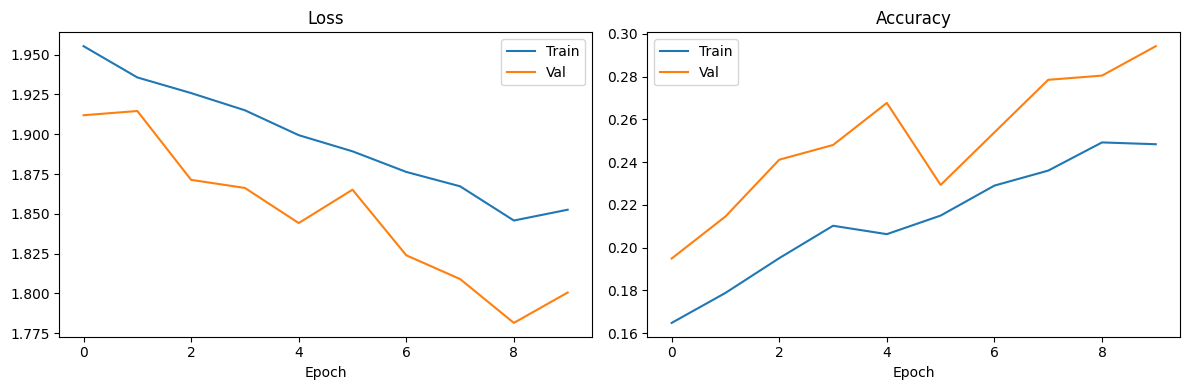

In [76]:
# Adjust learning rate for this architecture
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.01)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=5
)

# Train the model using the train_model function
train_losses, val_losses, train_accs, val_accs = train_model(
    model=model,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    model_name="Custom_EmotionNetV2"
)

Evaluating Custom Model V2:   0%|          | 0/16 [00:00<?, ?it/s]

/Users/siewweiheng/miniconda3/envs/adl-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/siewweiheng/miniconda3/envs/adl-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/siewweiheng/miniconda3/envs/adl-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

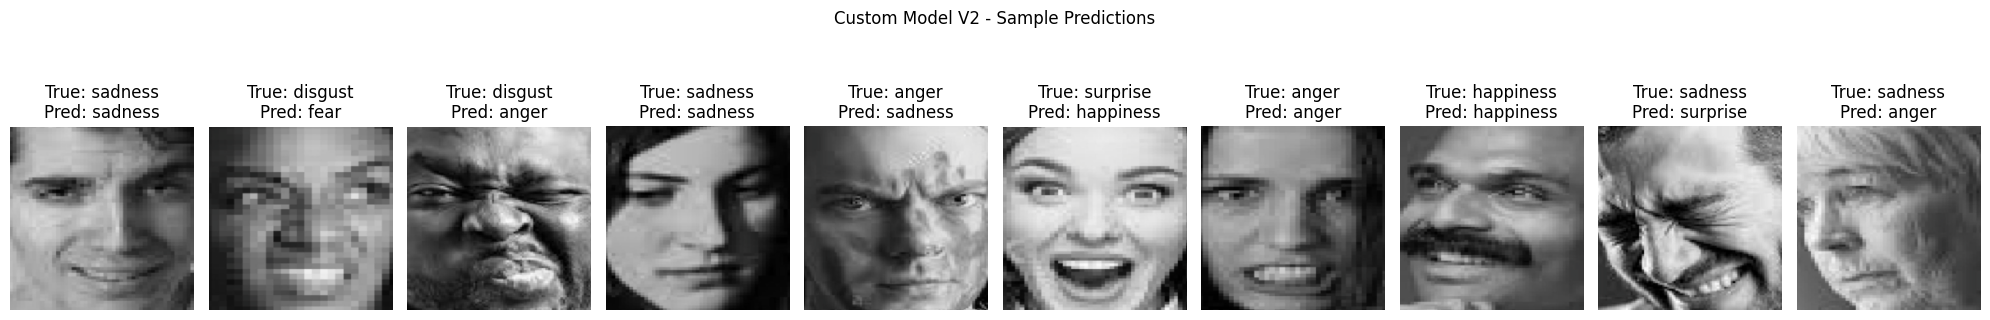

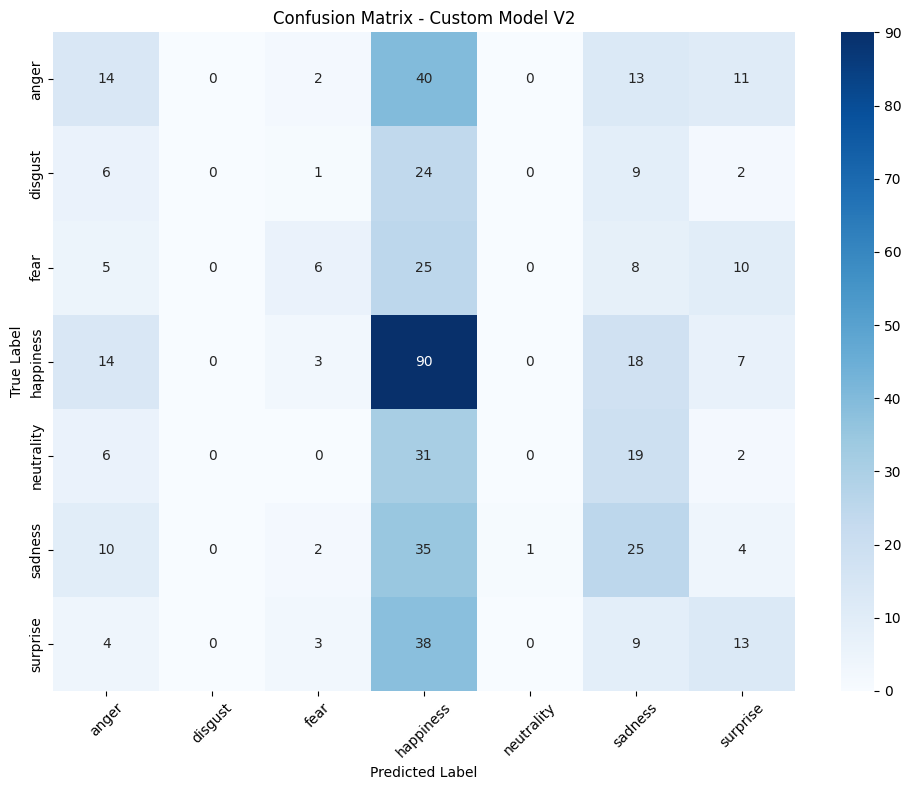


Classification Report - Custom Model V2
              precision    recall  f1-score   support

       anger      0.237     0.175     0.201        80
     disgust      0.000     0.000     0.000        42
        fear      0.353     0.111     0.169        54
   happiness      0.318     0.682     0.434       132
  neutrality      0.000     0.000     0.000        58
     sadness      0.248     0.325     0.281        77
    surprise      0.265     0.194     0.224        67

    accuracy                          0.290       510
   macro avg      0.203     0.212     0.187       510
weighted avg      0.229     0.290     0.234       510



In [77]:
custom_modelv2 = EmotionNetV2(num_classes=len(class_names)).to(device)
custom_modelv2.load_state_dict(torch.load("best_Custom_EmotionNetV2.pth"))

custom_acc, custom_cm, custom_report = evaluate_model(custom_modelv2, dataloaders["test"], device, "Custom Model V2")

In [78]:
# Benchmarking function
def benchmark_model(model, input_size=(1, 3, 224, 224), test_dataloader=None):
    model.eval()
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Model size in MB
    model_size = sum(p.numel() * p.element_size() for p in model.parameters()) / (
        1024 * 1024
    )

    # Test on actual dataset
    if test_dataloader:
        correct = 0
        total = 0
        test_times = []
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in tqdm(test_dataloader, desc="Testing"):
                inputs, labels = inputs.to(device), labels.to(device)

                start_time = time.time()
                outputs = model(inputs)
                torch.mps.synchronize()
                test_times.append(time.time() - start_time)

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = 100 * correct / total
        avg_test_time = sum(test_times) / len(test_times) * 1000  # Convert to ms

        # Calculate per-class metrics
        report = classification_report(
            all_labels, all_preds, target_names=class_names, output_dict=True
        )

        return {
            "Total Parameters": total_params,
            "Trainable Parameters": trainable_params,
            "Model Size (MB)": model_size,
            "Test Accuracy (%)": accuracy,
            "Avg Test Batch Time (ms)": avg_test_time,
            "Per-class Metrics": report,
        }

    return {
        "Total Parameters": total_params,
        "Trainable Parameters": trainable_params,
        "Model Size (MB)": model_size,
        "Avg Batch Inference Time (ms)": avg_inference_time,
    }


def benchmark_models(models_or_benchmarks, test_dataloader=None):
    """Create a comparison report of model benchmarks.

    Args:
        models_or_benchmarks: Either a dictionary of {model_name: model} or list of benchmark results
        test_dataloader: DataLoader for testing (required if passing models dictionary)
    """
    # Determine if we're dealing with models or benchmark results
    if isinstance(models_or_benchmarks, dict):
        # Convert models to benchmarks
        benchmarks = []
        model_names = []
        for name, model in models_or_benchmarks.items():
            benchmarks.append(benchmark_model(model, test_dataloader=test_dataloader))
            model_names.append(name)
    else:
        # Assume we have benchmark results and model names
        benchmarks = models_or_benchmarks[0]
        model_names = models_or_benchmarks[1]

    basic_metrics = [
        "Total Parameters",
        "Trainable Parameters",
        "Model Size (MB)",
        "Test Accuracy (%)",
        "Avg Test Batch Time (ms)",
    ]

    # Print header for basic metrics
    print("\nModel Performance Comparison:")
    header = "Metric".ljust(30)
    for name in model_names:
        header += name.ljust(20)
    print(header)
    print("-" * (30 + 20 * len(model_names)))

    # Print each basic metric row
    for metric in basic_metrics:
        if not any(metric in b for b in benchmarks):
            continue
        row = metric.ljust(30)
        for benchmark in benchmarks:
            val = benchmark.get(metric, "N/A")

            if isinstance(val, (int, float)):
                if metric.endswith("(ms)"):
                    row += f"{val:,.2f}ms".ljust(20)
                elif metric.endswith("(MB)"):
                    row += f"{val:,.2f}MB".ljust(20)
                elif metric.endswith("(%)"):
                    row += f"{val:,.2f}%".ljust(20)
                else:
                    row += f"{val:,}".ljust(20)
            else:
                row += str(val).ljust(20)
        print(row)

In [79]:
benchmark_models(
    {"Custom Model": custom_model, "Custom Model V2": custom_modelv2},
    test_dataloader=dataloaders["test"],
)

Testing:   0%|          | 0/16 [00:00<?, ?it/s]

/Users/siewweiheng/miniconda3/envs/adl-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/siewweiheng/miniconda3/envs/adl-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/siewweiheng/miniconda3/envs/adl-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

Testing:   0%|          | 0/16 [00:00<?, ?it/s]


Model Performance Comparison:
Metric                        Custom Model        Custom Model V2     
----------------------------------------------------------------------
Total Parameters              103,136,007         2,120,971           
Trainable Parameters          103,136,007         2,120,971           
Model Size (MB)               393.43MB            8.09MB              
Test Accuracy (%)             25.88%              29.02%              
Avg Test Batch Time (ms)      236.81ms            214.92ms            


/Users/siewweiheng/miniconda3/envs/adl-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/siewweiheng/miniconda3/envs/adl-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/siewweiheng/miniconda3/envs/adl-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

CustomModel V2 (EmotionNetV2):

Problems:
1. The two pathways still started separately - like having two people look at the same thing but starting from different positions
2. The attention system was too complex - like having too many people giving opinions at once
3. Not efficient in processing - took longer to process images (235.82ms vs V1's 115.45ms)
4. Still not focusing well enough on the right features

In [80]:
# Add Channel and Spatial Attention modules
class ChannelAttention(torch.nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = torch.nn.AdaptiveAvgPool2d(1)
        self.max_pool = torch.nn.AdaptiveMaxPool2d(1)

        self.fc = torch.nn.Sequential(
            torch.nn.Linear(channels, channels // reduction, bias=False),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(channels // reduction, channels, bias=False),
        )
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x).view(x.size(0), -1))
        max_out = self.fc(self.max_pool(x).view(x.size(0), -1))
        out = self.sigmoid(avg_out + max_out).view(x.size(0), x.size(1), 1, 1)
        return x * out


class SpatialAttention(torch.nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = torch.nn.Conv2d(
            2, 1, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = self.sigmoid(self.conv(x_cat))
        return x * out
        
class EmotionNetV3(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Shared initial layers with better initialization
        self.shared_features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(2),
        )

        # Local feature pathway with residual connections
        self.local_conv1 = self._make_local_block(32, 64)
        self.local_conv2 = self._make_local_block(64, 128)

        # Global feature pathway with attention
        self.global_conv1 = self._make_global_block(32, 64)
        self.global_conv2 = self._make_global_block(64, 128)

        # Dual attention mechanisms
        self.channel_attention = ChannelAttention(256)
        self.spatial_attention = SpatialAttention()

        # Final layers with better regularization
        self.final_conv = torch.nn.Sequential(
            torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(inplace=True),
            torch.nn.AdaptiveAvgPool2d((1, 1)),
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256, num_classes),
        )

    def _make_local_block(self, in_channels, out_channels):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(2),
        )

    def _make_global_block(self, in_channels, out_channels):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=5, padding=2),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=5, padding=2),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(2),
        )

    def forward(self, x):
        # Initial shared features
        x = self.shared_features(x)

        # Local pathway with residual connection
        local_features = self.local_conv1(x)
        local_features = self.local_conv2(local_features)

        # Global pathway
        global_features = self.global_conv1(x)
        global_features = self.global_conv2(global_features)

        # Combine features
        combined = torch.cat([local_features, global_features], dim=1)

        # Apply dual attention mechanisms
        combined = self.channel_attention(combined)
        combined = self.spatial_attention(combined)

        # Final processing
        features = self.final_conv(combined)
        features = features.view(features.size(0), -1)
        output = self.classifier(features)

        return output


# Create optimizer and scheduler for EmotionNetV3
model = EmotionNetV3(num_classes=len(class_names))
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
EmotionNetV3                             [1, 7]                    --
├─Sequential: 1-1                        [1, 32, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 32, 224, 224]         896
│    └─BatchNorm2d: 2-2                  [1, 32, 224, 224]         64
│    └─ReLU: 2-3                         [1, 32, 224, 224]         --
│    └─MaxPool2d: 2-4                    [1, 32, 112, 112]         --
├─Sequential: 1-2                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-5                       [1, 64, 112, 112]         18,496
│    └─BatchNorm2d: 2-6                  [1, 64, 112, 112]         128
│    └─ReLU: 2-7                         [1, 64, 112, 112]         --
│    └─Conv2d: 2-8                       [1, 64, 112, 112]         36,928
│    └─BatchNorm2d: 2-9                  [1, 64, 112, 112]         128
│    └─ReLU: 2-10                        [1, 64, 112, 112]         --
│   

CustomModel V3 (EmotionNetV3):
1. Most sophisticated architecture:
   - Shared initial features layer
     * Both eyes look at same spot before splitting their focus
     * Increased efficiency because skip processing same initial information twice
   - Dual attention mechanisms:
     * Channel attention (focuses on important feature channels) (Like having the ability to focus on specific types of features (e.g., "edges are really important for this expression")
     * Spatial attention (focuses on important spatial regions) (Like knowing exactly where to look on the face (e.g., "the mouth area is crucial for this emotion")
   - Better organized local and global pathways
2. Most efficient architecture (1.7M parameters)
3. Better regularization techniques
4. Simplified but effective classifier

*   **Shared Initial Layers:** V3 starts with `shared_features`, a sequential block of `Conv2d`, `BatchNorm2d`, `ReLU`, and `MaxPool2d` that is common to both local and global pathways. This is an efficiency improvement and potentially helps in learning more general initial features.
*   **Simplified Local and Global Blocks:** V3 uses `_make_local_block` and `_make_global_block` to create its pathway blocks. These blocks are simpler than V2's pathways and do not explicitly use `ResidualBlock` or `SelfAttention` within the blocks themselves.
    *   **Local Blocks (V3):** Use 3x3 convolutions (smaller kernel, focusing on local features).
    *   **Global Blocks (V3):** Use 5x5 convolutions (larger kernel, focusing on global context).
*   **Channel and Spatial Attention:** V3 replaces `SelfAttention` with separate `ChannelAttention` and `SpatialAttention` modules applied *after* the concatenation of local and global features. These attention mechanisms are distinct from the self-attention used in V2 and focus on channel-wise and spatial-wise feature importance respectively.
*   **Simplified Final Layers:** V3's final convolutional and classifier layers are more streamlined compared to V2's fusion and classifier modules. It uses a final `Conv2d` block followed by a simpler classifier.
*   **No Explicit Weight Initialization:** V3 does not have a separate weight initialization method in the provided code. It will rely on PyTorch's default initialization.


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 18:42:55,553 - INFO - Epoch 1/10
2025-02-20 18:42:55,554 - INFO - Train Loss: 1.8898 Acc: 0.2259
2025-02-20 18:42:55,555 - INFO - Val Loss: 1.8572 Acc: 0.2579
/Users/siewweiheng/miniconda3/envs/adl-1/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving best model checkpoint...


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 18:45:00,273 - INFO - Epoch 2/10
2025-02-20 18:45:00,274 - INFO - Train Loss: 1.8500 Acc: 0.2624
2025-02-20 18:45:00,275 - INFO - Val Loss: 1.8302 Acc: 0.2717


Saving best model checkpoint...


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 18:47:04,732 - INFO - Epoch 3/10
2025-02-20 18:47:04,733 - INFO - Train Loss: 1.8356 Acc: 0.2641
2025-02-20 18:47:04,735 - INFO - Val Loss: 1.8225 Acc: 0.2835


Saving best model checkpoint...


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 18:49:10,802 - INFO - Epoch 4/10
2025-02-20 18:49:10,803 - INFO - Train Loss: 1.8218 Acc: 0.2748
2025-02-20 18:49:10,804 - INFO - Val Loss: 1.8023 Acc: 0.2687


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 18:51:12,657 - INFO - Epoch 5/10
2025-02-20 18:51:12,659 - INFO - Train Loss: 1.8165 Acc: 0.2750
2025-02-20 18:51:12,660 - INFO - Val Loss: 1.7877 Acc: 0.2697


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 18:53:18,072 - INFO - Epoch 6/10
2025-02-20 18:53:18,074 - INFO - Train Loss: 1.8171 Acc: 0.2745
2025-02-20 18:53:18,075 - INFO - Val Loss: 1.7773 Acc: 0.3041


Saving best model checkpoint...


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 18:55:21,436 - INFO - Epoch 7/10
2025-02-20 18:55:21,438 - INFO - Train Loss: 1.8098 Acc: 0.2765
2025-02-20 18:55:21,438 - INFO - Val Loss: 1.7730 Acc: 0.3159


Saving best model checkpoint...


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 18:57:26,385 - INFO - Epoch 8/10
2025-02-20 18:57:26,387 - INFO - Train Loss: 1.7971 Acc: 0.2736
2025-02-20 18:57:26,387 - INFO - Val Loss: 1.7440 Acc: 0.3031


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 18:59:31,350 - INFO - Epoch 9/10
2025-02-20 18:59:31,351 - INFO - Train Loss: 1.7871 Acc: 0.2857
2025-02-20 18:59:31,352 - INFO - Val Loss: 1.7310 Acc: 0.3150


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 19:01:36,140 - INFO - Epoch 10/10
2025-02-20 19:01:36,141 - INFO - Train Loss: 1.7684 Acc: 0.3009
2025-02-20 19:01:36,142 - INFO - Val Loss: 1.7603 Acc: 0.3100


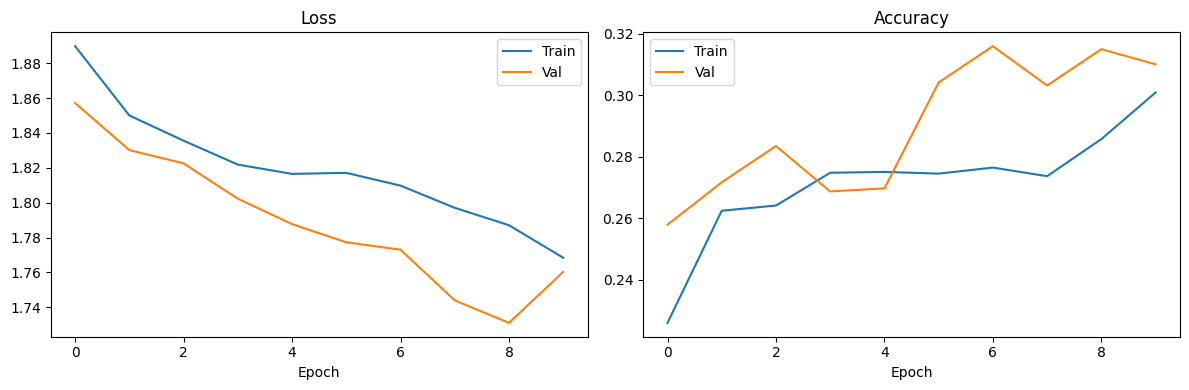

In [81]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.001,
    epochs=CONFIG["num_epochs"],
    steps_per_epoch=len(dataloaders["train"]),
    pct_start=0.3,
    div_factor=25,
    final_div_factor=1000,
)

# Train the model using the train_model function
train_losses, val_losses, train_accs, val_accs = train_model(
    model=model,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    model_name="Custom_EmotionNetV3"
)

Evaluating Custom Model V3:   0%|          | 0/16 [00:00<?, ?it/s]

/Users/siewweiheng/miniconda3/envs/adl-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/siewweiheng/miniconda3/envs/adl-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/siewweiheng/miniconda3/envs/adl-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

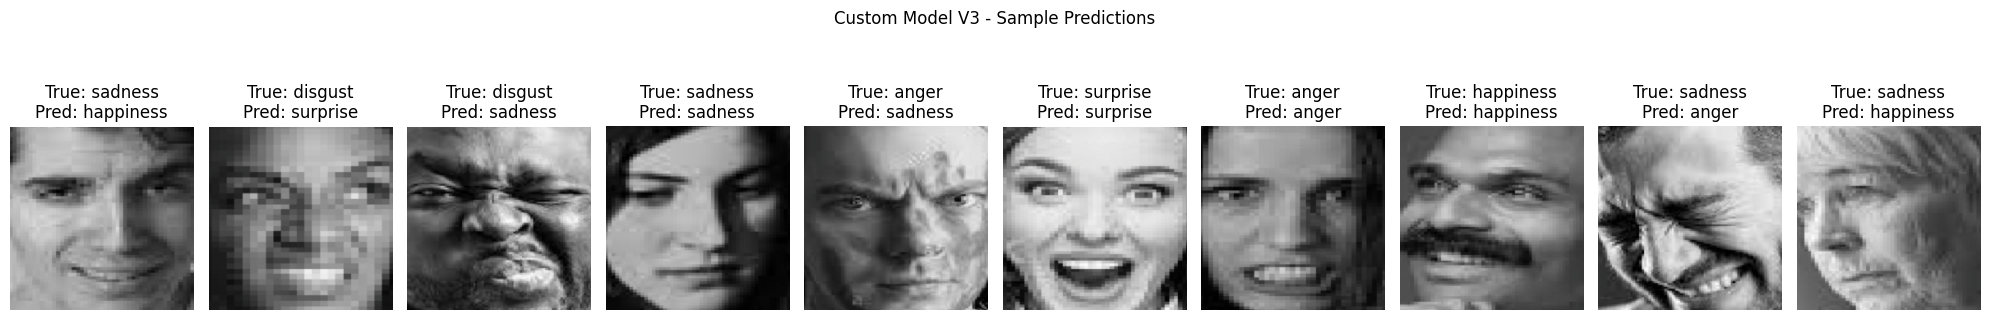

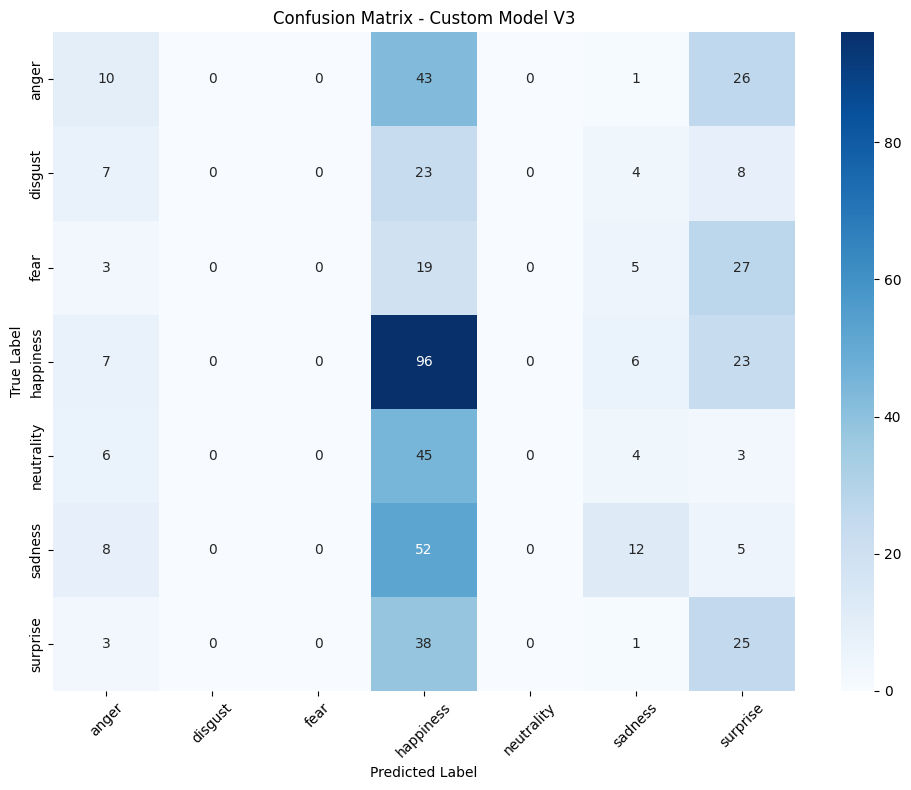


Classification Report - Custom Model V3
              precision    recall  f1-score   support

       anger      0.227     0.125     0.161        80
     disgust      0.000     0.000     0.000        42
        fear      0.000     0.000     0.000        54
   happiness      0.304     0.727     0.429       132
  neutrality      0.000     0.000     0.000        58
     sadness      0.364     0.156     0.218        77
    surprise      0.214     0.373     0.272        67

    accuracy                          0.280       510
   macro avg      0.158     0.197     0.154       510
weighted avg      0.197     0.280     0.205       510



In [82]:
custom_modelv3 = EmotionNetV3(num_classes=len(class_names)).to(device)
custom_modelv3.load_state_dict(torch.load("best_Custom_EmotionNetV3.pth"))
custom_acc, custom_cm, custom_report = evaluate_model(custom_modelv3, dataloaders["test"], device, "Custom Model V3")

In [83]:
benchmark_models(
    {"Custom Model": custom_model, "Custom Model V2": custom_modelv2, "Custom Model V3": custom_modelv3},
    test_dataloader=dataloaders["test"],
)

Testing:   0%|          | 0/16 [00:00<?, ?it/s]

/Users/siewweiheng/miniconda3/envs/adl-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/siewweiheng/miniconda3/envs/adl-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/siewweiheng/miniconda3/envs/adl-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

Testing:   0%|          | 0/16 [00:00<?, ?it/s]

/Users/siewweiheng/miniconda3/envs/adl-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/siewweiheng/miniconda3/envs/adl-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/siewweiheng/miniconda3/envs/adl-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

Testing:   0%|          | 0/16 [00:00<?, ?it/s]


Model Performance Comparison:
Metric                        Custom Model        Custom Model V2     Custom Model V3     
------------------------------------------------------------------------------------------
Total Parameters              103,136,007         2,120,971           1,714,218           
Trainable Parameters          103,136,007         2,120,971           1,714,218           
Model Size (MB)               393.43MB            8.09MB              6.54MB              
Test Accuracy (%)             25.88%              29.02%              28.04%              
Avg Test Batch Time (ms)      209.64ms            220.87ms            158.33ms            


/Users/siewweiheng/miniconda3/envs/adl-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/siewweiheng/miniconda3/envs/adl-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/siewweiheng/miniconda3/envs/adl-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

Key Takeaway:
The evolution shows how sometimes:
- Less is more (103M → 1.7M parameters)
- Working smarter beats working harder
- Organization and focus beat raw power

### Transfer Learning

In [84]:
model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = torch.nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)
summary(model, input_size=(1, 3, 224, 224))



Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 7]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 19:05:02,344 - INFO - Epoch 1/10
2025-02-20 19:05:02,346 - INFO - Train Loss: 1.7389 Acc: 0.3186
2025-02-20 19:05:02,346 - INFO - Val Loss: 1.4232 Acc: 0.4596


Saving best model checkpoint...


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 19:06:40,577 - INFO - Epoch 2/10
2025-02-20 19:06:40,579 - INFO - Train Loss: 1.4890 Acc: 0.4227
2025-02-20 19:06:40,579 - INFO - Val Loss: 1.2091 Acc: 0.5404


Saving best model checkpoint...


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 19:08:14,936 - INFO - Epoch 3/10
2025-02-20 19:08:14,938 - INFO - Train Loss: 1.3725 Acc: 0.4780
2025-02-20 19:08:14,939 - INFO - Val Loss: 1.1590 Acc: 0.5787


Saving best model checkpoint...


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 19:09:51,031 - INFO - Epoch 4/10
2025-02-20 19:09:51,034 - INFO - Train Loss: 1.2893 Acc: 0.4982
2025-02-20 19:09:51,034 - INFO - Val Loss: 1.1988 Acc: 0.5384


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 19:11:28,524 - INFO - Epoch 5/10
2025-02-20 19:11:28,527 - INFO - Train Loss: 1.2241 Acc: 0.5232
2025-02-20 19:11:28,528 - INFO - Val Loss: 1.0751 Acc: 0.5965


Saving best model checkpoint...


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 19:13:06,652 - INFO - Epoch 6/10
2025-02-20 19:13:06,654 - INFO - Train Loss: 1.1705 Acc: 0.5619
2025-02-20 19:13:06,655 - INFO - Val Loss: 1.0902 Acc: 0.5906


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 19:14:43,498 - INFO - Epoch 7/10
2025-02-20 19:14:43,500 - INFO - Train Loss: 1.1245 Acc: 0.5782
2025-02-20 19:14:43,501 - INFO - Val Loss: 1.0701 Acc: 0.6033


Saving best model checkpoint...


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 19:16:20,798 - INFO - Epoch 8/10
2025-02-20 19:16:20,800 - INFO - Train Loss: 1.0697 Acc: 0.5930
2025-02-20 19:16:20,801 - INFO - Val Loss: 1.1000 Acc: 0.6073


Saving best model checkpoint...


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 19:17:58,452 - INFO - Epoch 9/10
2025-02-20 19:17:58,454 - INFO - Train Loss: 1.0490 Acc: 0.6062
2025-02-20 19:17:58,455 - INFO - Val Loss: 1.1385 Acc: 0.6033


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 19:19:35,919 - INFO - Epoch 10/10
2025-02-20 19:19:35,921 - INFO - Train Loss: 1.0065 Acc: 0.6152
2025-02-20 19:19:35,922 - INFO - Val Loss: 1.1121 Acc: 0.6063


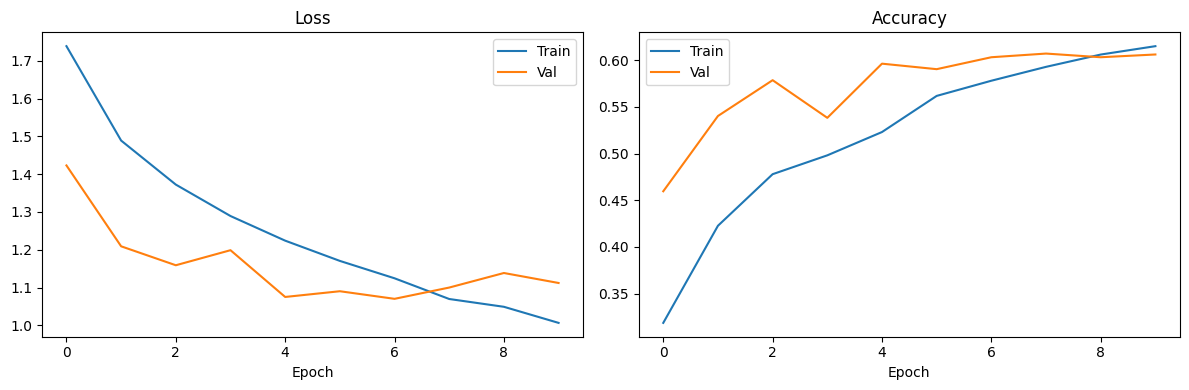

In [85]:
# For ResNet18 (Transfer Learning)
criterion = torch.nn.CrossEntropyLoss()
# Lower learning rate for transfer learning
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode="min", 
    factor=0.1, 
    patience=3,  # More aggressive LR reduction
)

# Train the model using the train_model function
train_losses, val_losses, train_accs, val_accs = train_model(
    model=model,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    model_name="ResNet18"
)

Evaluating ResNet18:   0%|          | 0/16 [00:00<?, ?it/s]

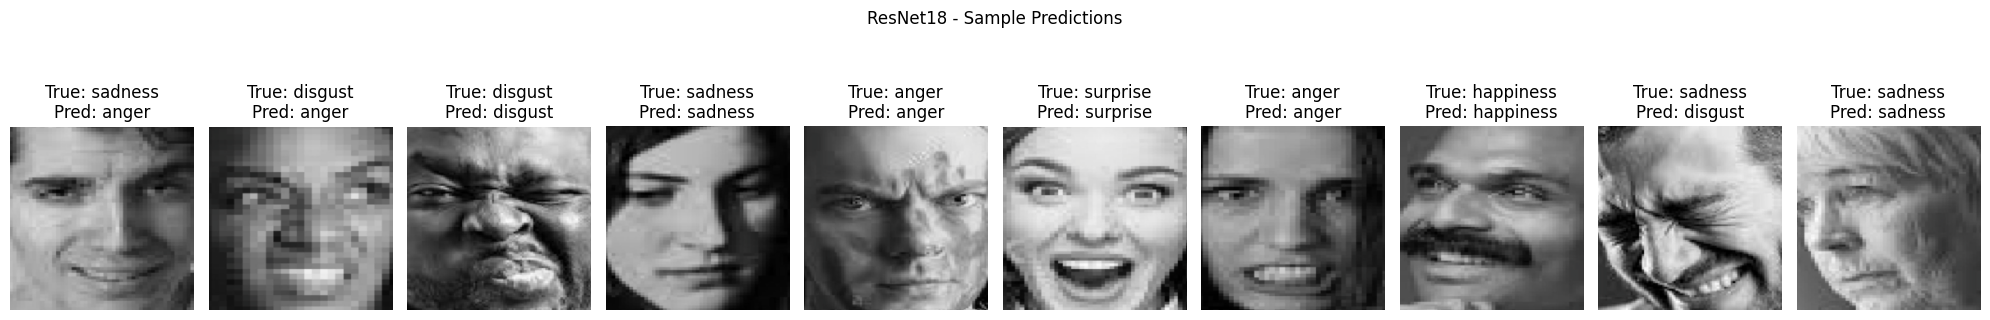

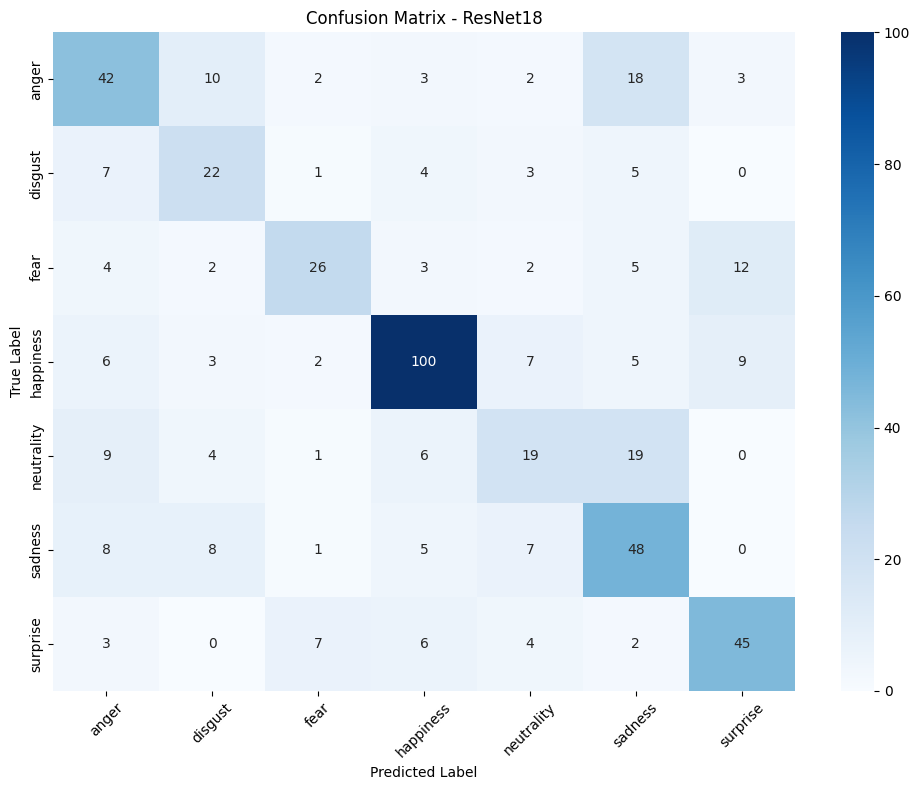


Classification Report - ResNet18
              precision    recall  f1-score   support

       anger      0.532     0.525     0.528        80
     disgust      0.449     0.524     0.484        42
        fear      0.650     0.481     0.553        54
   happiness      0.787     0.758     0.772       132
  neutrality      0.432     0.328     0.373        58
     sadness      0.471     0.623     0.536        77
    surprise      0.652     0.672     0.662        67

    accuracy                          0.592       510
   macro avg      0.568     0.559     0.558       510
weighted avg      0.599     0.592     0.591       510



In [86]:
resnet18_model = models.resnet18(weights=None)
resnet18_model.fc = torch.nn.Linear(resnet18_model.fc.in_features, len(class_names))
resnet18_model = resnet18_model.to(device)
resnet18_model.load_state_dict(torch.load("best_ResNet18.pth"))

resnet_acc, resnet_cm, resnet_report = evaluate_model(resnet18_model, dataloaders["test"], device, "ResNet18")

In [87]:
benchmark_models(
    {"Custom Model V3": custom_modelv3, "ResNet18": resnet18_model},
    test_dataloader=dataloaders["test"],
)

Testing:   0%|          | 0/16 [00:00<?, ?it/s]

/Users/siewweiheng/miniconda3/envs/adl-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/siewweiheng/miniconda3/envs/adl-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/siewweiheng/miniconda3/envs/adl-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

Testing:   0%|          | 0/16 [00:00<?, ?it/s]


Model Performance Comparison:
Metric                        Custom Model V3     ResNet18            
----------------------------------------------------------------------
Total Parameters              1,714,218           11,180,103          
Trainable Parameters          1,714,218           11,180,103          
Model Size (MB)               6.54MB              42.65MB             
Test Accuracy (%)             28.04%              59.22%              
Avg Test Batch Time (ms)      147.56ms            81.97ms             


In [94]:
model = models.resnet50(weights="IMAGENET1K_V2")
model.fc = torch.nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)

summary(model, input_size=(1, 3, CONFIG["image_size"], CONFIG["image_size"]))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 7]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-02-20 21:08:54,427 - INFO - Epoch 1/10
2025-02-20 21:08:54,431 - INFO - Train Loss: 1.7949 Acc: 0.2877
2025-02-20 21:08:54,432 - INFO - Val Loss: 1.9151 Acc: 0.2972


Saving best model checkpoint...


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

python(56002) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56009) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56016) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56022) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2025-02-20 21:16:38,035 - INFO - Epoch 2/10
2025-02-20 21:16:38,039 - INFO - Train Loss: 1.6771 Acc: 0.3292
2025-02-20 21:16:38,040 - INFO - Val Loss: 1.9125 Acc: 0.2333


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

python(56067) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56073) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56080) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56086) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

python(56675) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56682) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56689) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56690) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2025-02-20 21:23:57,399 - INFO - Epoch 3/10
2025-02-20 21:23:57,402 - INFO - Train Loss: 1.6273 Acc: 0.3595
2025-02-20 21:23:57,403 - INFO - Val Loss: 1.6645 Acc: 0.3858


Saving best model checkpoint...


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

python(56744) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56754) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56760) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56766) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

python(57221) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(57227) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(57234) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(57235) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2025-02-20 21:29:28,076 - INFO - Epoch 4/10
2025-02-20 21:29:28,079 - INFO - Train Loss: 1.5657 Acc: 0.3932
2025-02-20 21:29:28,079 - INFO - Val Loss: 1.3953 Acc: 0.4793


Saving best model checkpoint...


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

python(57279) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(57286) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(57292) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(57299) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

python(57723) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(57730) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(57738) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(57744) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2025-02-20 21:34:33,775 - INFO - Epoch 5/10
2025-02-20 21:34:33,782 - INFO - Train Loss: 1.5215 Acc: 0.4154
2025-02-20 21:34:33,783 - INFO - Val Loss: 1.3740 Acc: 0.4843


Saving best model checkpoint...


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

python(57792) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(57798) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(57806) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(57812) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

python(58229) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(58235) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(58242) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(58243) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2025-02-20 21:39:28,443 - INFO - Epoch 6/10
2025-02-20 21:39:28,445 - INFO - Train Loss: 1.4886 Acc: 0.4171
2025-02-20 21:39:28,446 - INFO - Val Loss: 1.4254 Acc: 0.4744


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

python(58288) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(58294) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(58300) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(58307) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

python(58820) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(58827) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(58833) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(58839) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2025-02-20 21:45:26,909 - INFO - Epoch 7/10
2025-02-20 21:45:26,912 - INFO - Train Loss: 1.4528 Acc: 0.4280
2025-02-20 21:45:26,913 - INFO - Val Loss: 1.3133 Acc: 0.5108


Saving best model checkpoint...


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

python(58885) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(58891) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(58898) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(58899) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

python(59246) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(59252) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(59259) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(59265) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2025-02-20 21:50:28,023 - INFO - Epoch 8/10
2025-02-20 21:50:28,028 - INFO - Train Loss: 1.4453 Acc: 0.4446
2025-02-20 21:50:28,029 - INFO - Val Loss: 1.3276 Acc: 0.5157


Saving best model checkpoint...


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

python(59313) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(59319) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(59326) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(59332) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

python(59708) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(59709) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(59715) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(59723) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2025-02-20 21:55:03,406 - INFO - Epoch 9/10
2025-02-20 21:55:03,408 - INFO - Train Loss: 1.4210 Acc: 0.4541
2025-02-20 21:55:03,408 - INFO - Val Loss: 1.3256 Acc: 0.5217


Saving best model checkpoint...


Training Phase:   0%|          | 0/111 [00:00<?, ?it/s]

python(59770) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(59777) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(59783) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(59793) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

python(60108) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(60115) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(60116) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(60122) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2025-02-20 21:59:03,048 - INFO - Epoch 10/10
2025-02-20 21:59:03,054 - INFO - Train Loss: 1.3835 Acc: 0.4620
2025-02-20 21:59:03,055 - INFO - Val Loss: 1.2848 Acc: 0.5098


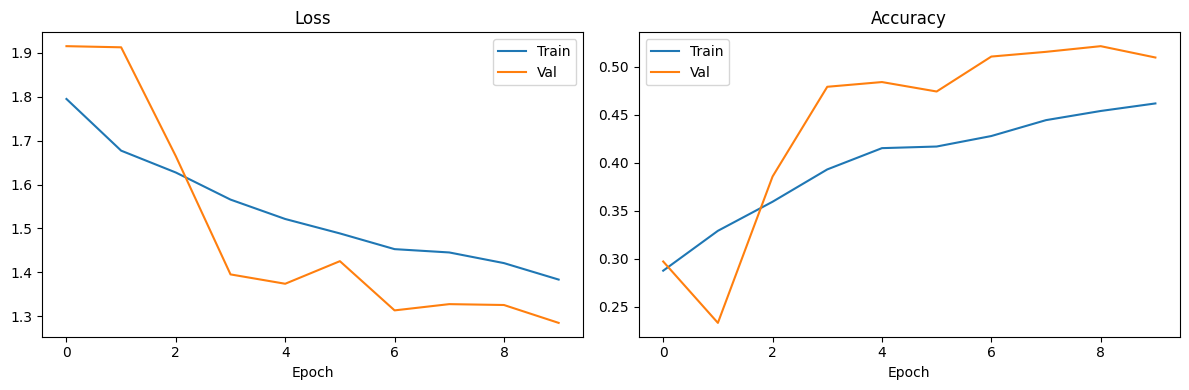

In [95]:
# Setup training
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    model.parameters(),
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.1,
    patience=3,
    verbose=True
)

# Train model
train_losses, val_losses, train_accs, val_accs = train_model(
    model=model,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    model_name="ResNet50"
)

Evaluating ResNet50:   0%|          | 0/16 [00:00<?, ?it/s]

python(8039) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8040) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8041) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8042) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


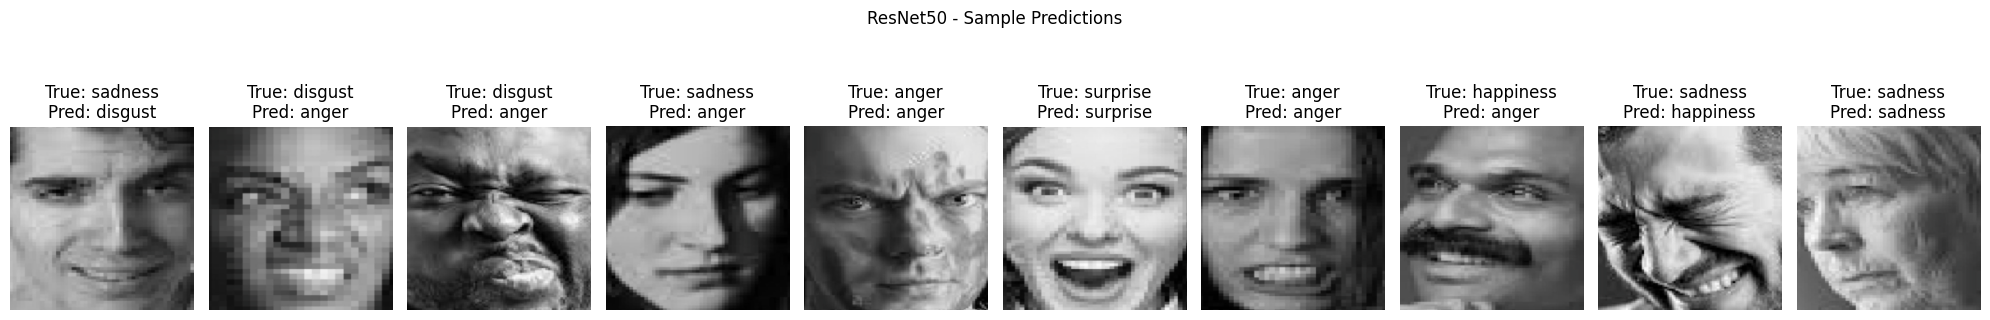

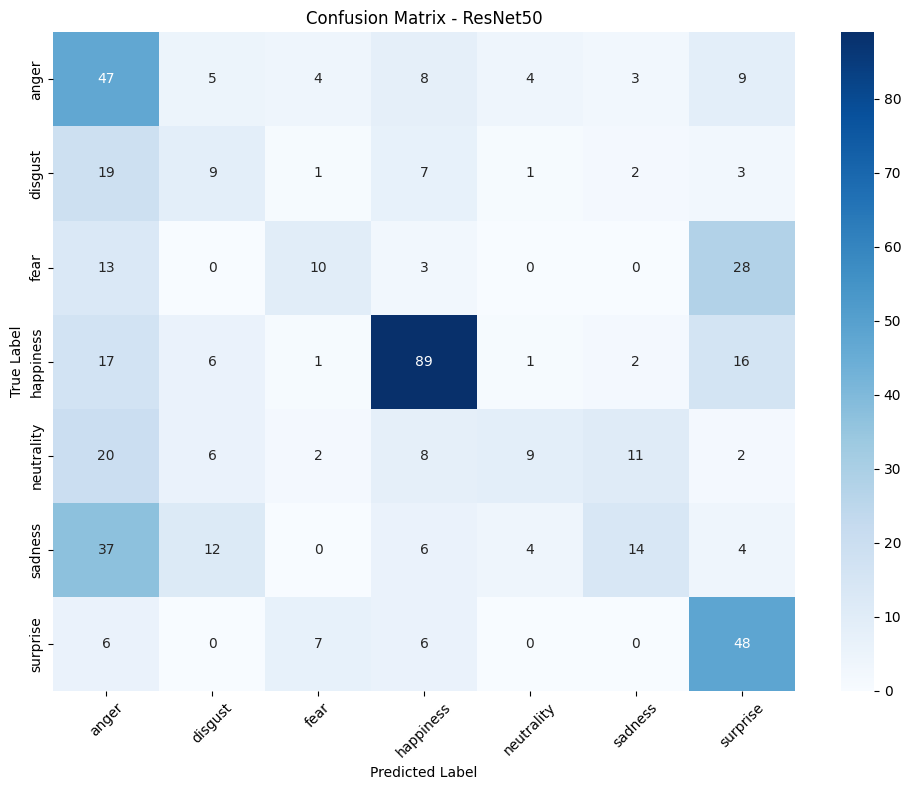


Classification Report - ResNet50
              precision    recall  f1-score   support

       anger      0.296     0.588     0.393        80
     disgust      0.237     0.214     0.225        42
        fear      0.400     0.185     0.253        54
   happiness      0.701     0.674     0.687       132
  neutrality      0.474     0.155     0.234        58
     sadness      0.438     0.182     0.257        77
    surprise      0.436     0.716     0.542        67

    accuracy                          0.443       510
   macro avg      0.426     0.388     0.370       510
weighted avg      0.467     0.443     0.422       510



In [98]:
resnet50_model = models.resnet50(weights=None)
resnet50_model.fc = torch.nn.Linear(resnet50_model.fc.in_features, len(class_names))
resnet50_model = resnet50_model.to(device)
resnet50_model.load_state_dict(torch.load("best_ResNet50.pth"))

resnet_acc, resnet_cm, resnet_report = evaluate_model(resnet50_model, dataloaders["test"], device, "ResNet50")

In [99]:
benchmark_models(
    {"Custom Model V3": custom_modelv3, "ResNet18": resnet18_model, "ResNet50": resnet50_model},
    test_dataloader=dataloaders["test"],
)

Testing:   0%|          | 0/16 [00:00<?, ?it/s]

python(8097) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8098) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8099) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8100) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/siewweiheng/miniconda3/envs/adl-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/siewweiheng/miniconda3/envs/adl-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Testing:   0%|          | 0/16 [00:00<?, ?it/s]

python(8135) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8136) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8137) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8138) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Testing:   0%|          | 0/16 [00:00<?, ?it/s]

python(8176) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8177) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8178) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8179) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



Model Performance Comparison:
Metric                        Custom Model V3     ResNet18            ResNet50            
------------------------------------------------------------------------------------------
Total Parameters              1,714,218           11,180,103          23,522,375          
Trainable Parameters          1,714,218           11,180,103          23,522,375          
Model Size (MB)               6.54MB              42.65MB             89.73MB             
Test Accuracy (%)             28.04%              59.22%              44.31%              
Avg Test Batch Time (ms)      168.37ms            278.23ms            226.89ms            


ResNet outperformed the custom model by a huge margin, doing better in almost every class.

This is despite having much lower training times than the custom model.

The custom model overfitted to the training data. Thus, we need to recognize the additional work and experience needed to tune our custom model so that it performs optimally.

Other reasons why ResNet performed better includes:
- ResNet18 has deeper connections (18 trainable layers vs our 6 trainable layers)
    - Thus, ResNet18 fine-tuned is a larger and more complex model but with the use of transfer learning, compute times are shorter than a custom model, even of a smaller size.
    - This is because for transfer learning, the model starts closer to an optimal solution, and less adjustments are needed. 
- ResNet18's architecture is much more optimized than our model, through years of research (https://arxiv.org/abs/1512.03385)

Interestingly, the custom model has much larger model size. This shouldn't be the case, and signifies a problem in our modelling step, since ResNet18 has 18 trainable layers. There was likely a calculation mistake.

| Aspect | ResNet18 (Transfer Learning) | Custom EmotionNet |
|--------|----------------------------|-------------------|
| **Training Time** | ✅ Faster training (10 epochs sufficient) | ❌ Requires more epochs to converge |
| **Performance** | ✅ Better accuracy and per-class metrics | ❌ Lower overall accuracy |
| **Model Size** | ❌ Larger model (~44M parameters) | ✅ Smaller model size (fewer parameters) |
| **Feature Extraction** | ✅ Pre-learned generic image features | ❌ Has to learn features from scratch |
| **Domain Specificity** | ❌ Generic ImageNet features need adaptation | ✅ Architecture designed specifically for emotion recognition |
| **Resource Requirements** | ❌ Higher memory usage | ✅ Lower memory footprint |
| **Flexibility** | ❌ Fixed architecture constraints | ✅ Can modify architecture easily |
| **Interpretability** | ❌ Complex, harder to interpret | ✅ Simpler architecture, easier to understand |
| **Initialization** | ✅ Starts with meaningful weights | ❌ Random initialization |
| **Data Requirements** | ✅ Works well with smaller datasets | ❌ Needs more data for good performance |
| **Dual Pathway Design** | ❌ Single pathway architecture | ✅ Specialized local and global feature pathways |
| **Computational Cost** | ❌ More computationally intensive | ✅ Lighter computational requirements |
